# Importing necessary libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Parsing data from XML and converting it into CSV

In [2]:
path = glob('Image_Dataset/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [3]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,Image_Dataset\AN1.xml,94,185,364,385
1,Image_Dataset\AN10.xml,109,165,168,181
2,Image_Dataset\AN2.xml,121,179,224,237
3,Image_Dataset\AN4.xml,82,141,229,245
4,Image_Dataset\AN5.xml,150,205,244,256


In [4]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('Image_Dataset',filename_image)
    return filepath_image
getFilename(filename)

'Image_Dataset\\AN1.jpg'

In [5]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['Image_Dataset\\AN1.jpg',
 'Image_Dataset\\AN10.jpg',
 'Image_Dataset\\AN2.jpg',
 'Image_Dataset\\AN4.jpg',
 'Image_Dataset\\AN5.jpg',
 'Image_Dataset\\AN6.jpg',
 'Image_Dataset\\AN7.jpg',
 'Image_Dataset\\AP1.jpg',
 'Image_Dataset\\AP10.jpg',
 'Image_Dataset\\AP12.jpg']

# Data Preprocessing

In [7]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    print(f"Reading image from: {image}")  # Check the image path
    img_arr = cv2.imread(image)
    # Check if the image was read successfully
    if img_arr is None:
        print(f"Failed to read image: {image}")
        continue  # Skip to the next iteration if the image couldn't be read

    # Proceed if the image was successfully read
    h, w, d = img_arr.shape
    
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

Reading image from: Image_Dataset\AN1.jpg
Reading image from: Image_Dataset\AN10.jpg
Reading image from: Image_Dataset\AN2.jpg
Reading image from: Image_Dataset\AN4.jpg
Reading image from: Image_Dataset\AN5.jpg
Reading image from: Image_Dataset\AN6.jpg
Reading image from: Image_Dataset\AN7.jpg
Reading image from: Image_Dataset\AP1.jpg
Reading image from: Image_Dataset\AP10.jpg
Reading image from: Image_Dataset\AP12.jpg
Reading image from: Image_Dataset\AP13.jpg
Reading image from: Image_Dataset\AP14.jpg
Reading image from: Image_Dataset\AP15.jpg
Reading image from: Image_Dataset\AP16.jpg
Reading image from: Image_Dataset\AP17.jpg
Reading image from: Image_Dataset\AP18.jpg
Reading image from: Image_Dataset\AP19.jpg
Reading image from: Image_Dataset\AP2.jpg
Reading image from: Image_Dataset\AP20.jpg
Reading image from: Image_Dataset\AP21.jpg
Reading image from: Image_Dataset\AP22.jpg
Reading image from: Image_Dataset\AP23.jpg
Reading image from: Image_Dataset\AP24.jpg
Reading image from:

In [9]:
print(f"Processed Images: {len(data)}")
print(f"Output Labels: {len(output)}")


Processed Images: 601
Output Labels: 601


# Split Train and Test set

In [10]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [11]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((480, 224, 224, 3), (121, 224, 224, 3), (480, 4), (121, 4))

# Deep Learning for object Detection

In [13]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [14]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_203 (Conv2D)           │ (None, 111, 111, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_203       │ (None, 111, 111, 32)      │              96 │ conv2d_203[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_203 (Activation)   │ (None, 111, 111, 32)      │               0 │ batch_normalization_203[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_204 (Conv2D)           │ (None, 109, 109, 32)      │           9,216 │ activation_203[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_204       │ (None, 109, 109, 32)      │              96 │ conv2d_204[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_204 (Activation)   │ (None, 109, 109, 32)      │               0 │ batch_normalization_204[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_205 (Conv2D)           │ (None, 109, 109, 64)      │          18,432 │ activation_204[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_205       │ (None, 109, 109, 64)      │             192 │ conv2d_205[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_205 (Activation)   │ (None, 109, 109, 64)      │               0 │ batch_normalization_205[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 54, 54, 64)        │               0 │ activation_205[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_206 (Conv2D)           │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_206       │ (None, 54, 54, 80)        │             240 │ conv2d_206[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_206 (Activation)   │ (None, 54, 54, 80)        │               0 │ batch_normalization_206[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_207 (Conv2D)           │ (None, 52, 52, 192)       │         138,24

 Total params: 73,663,490 (281.00 MB)

 Trainable params: 73,602,946 (280.77 MB)

 Non-trainable params: 60,544 (236.50 KB)

# Inception RESNET-V2 Training

In [15]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=18,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/18


C:\Users\aditi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: ['keras_tensor_784']. Received: the structure of inputs=*



48/48 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - loss: 0.0485 - val_loss: 0.0161
Epoch 2/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.0077 - val_loss: 0.0080
Epoch 3/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 0.0033 - val_loss: 0.0066
Epoch 4/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 0.0022 - val_loss: 0.0163
Epoch 5/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - loss: 0.0021 - val_loss: 0.0139
Epoch 6/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - loss: 0.0013 - val_loss: 0.0251
Epoch 7/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 0.0037 - val_loss: 0.0225
Epoch 8/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - loss: 0.0012 - val_loss: 0.0195
Epoch 9/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - loss: 7.6781e-04 - val_loss: 0.0136
Epoch 10/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 5.6935e-04 - val_loss: 0.0145
Epoch 11/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - loss: 4.7539e-04 - val_loss: 0.0129
Epoch 12/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - loss: 4.

In [17]:
#model.save('./number_plate_detection.h5')
model.save('./number_plate_detection.keras')

# Make Predictions

In [18]:
# Load model
model = tf.keras.models.load_model('./number_plate_detection.keras')
print('Model loaded Sucessfully')

Model loaded Sucessfully


C:\Users\aditi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 496 variables whereas the saved optimizer has 990 variables. 



In [37]:
from PIL import Image
from IPython.display import display

In [38]:
# Define the image path
path = 'Image_Testing/test.jpg'

# Load and convert the image to a numpy array
image = load_img(path)  # PIL object
image = np.array(image, dtype=np.uint8)  # 8-bit array (0, 255)

# Resize the image to (224, 224)
image1 = load_img(path, target_size=(224, 224))
image_arr_224 = img_to_array(image1) / 255.0  # Normalize the image array

# Get the dimensions of the original image
h, w, d = image.shape
print('Height of the image =', h)
print('Width of the image =', w)

Height of the image = 384
Width of the image = 288


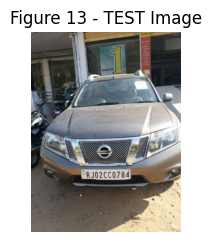

In [40]:
# Display the original image using Matplotlib
plt.figure(figsize=(7, 5))  # Set the figure size to 700x500 pixels
plt.imshow(image)      # Display the image
plt.axis('off')              # Hide axes
plt.title('Figure 13 - TEST Image')  # Title for the image
plt.tight_layout(pad=10)     # Adjust layout to prevent clipping
plt.show()                   # Show the image

In [41]:
image_arr_224.shape

(224, 224, 3)

In [42]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

# Bounding box

In [43]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.3206468 , 0.67269707, 0.67629975, 0.72712004]], dtype=float32)

In [44]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[ 92.34627628, 193.73675537, 259.69910431, 279.21409607]])

In [45]:
coords = coords.astype(np.int32)
coords

array([[ 92, 193, 259, 279]], dtype=int32)

In [46]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(np.int32(92), np.int32(259)) (np.int32(193), np.int32(279))


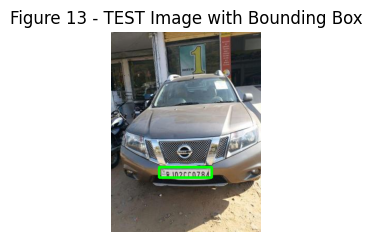

In [47]:
# Draw bounding box on the image
cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)  # Green rectangle with thickness 3

# Display the image with the bounding box using Matplotlib
plt.figure(figsize=(7, 5))  # Set the figure size to 700x500 pixels
plt.imshow(image)      # Display the image with bounding box
plt.axis('off')              # Hide axes
plt.title('Figure 13 - TEST Image with Bounding Box')  # Title for the image
plt.tight_layout(pad=10)     # Adjust layout to prevent clipping
plt.show()     

# Create pipeline

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
(np.int32(77), np.int32(397)) (np.int32(183), np.int32(422))


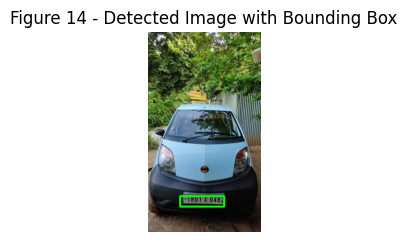

In [77]:
# Create pipeline
path = 'TR5.jpg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h, w, d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

# Display the image with bounding box using Matplotlib
plt.figure(figsize=(7, 5))  # Set the figure size to 700x500 pixels
plt.imshow(image)            # Display the image with bounding box
plt.axis('off')              # Hide axes
plt.title('Figure 14 - Detected Image with Bounding Box')  # Title for the image
plt.tight_layout(pad=10)     # Adjust layout to prevent clipping
plt.show()  

# Optical Character Recognition

C:\Users\aditi\AppData\Local\Temp\ipykernel_3164\3957730498.py:10: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



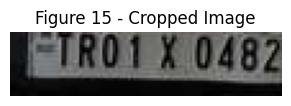

In [78]:
img = np.array(load_img(path))
xmin, xmax, ymin, ymax = cods[0]
roi = img[ymin:ymax, xmin:xmax]

# Display the cropped image using Matplotlib
plt.figure(figsize=(3.5, 2.5))  # Set the figure size to 350x250 pixels
plt.imshow(roi)                  # Display the cropped image
plt.axis('off')                  # Hide axes
plt.title('Figure 15 - Cropped Image')  # Title for the cropped image
plt.tight_layout(pad=10)         # Adjust layout to prevent clipping
plt.show()                       # Show the cropped image

In [80]:
import easyocr

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])  # Specify the languages you want to read

# Extract text from the cropped image
text = reader.readtext(roi)

# Initialize a dictionary for license plate prefixes
states_mapping = {
    "AN": "Andaman and Nicobar Islands",
    "AP": "Andhra Pradesh",
    "AR": "Arunachal Pradesh",
    "AS": "Assam",
    "BR": "Bihar",
    "CG": "Chhattisgarh",
    "CH": "Chandigarh",
    "DD": "Daman and Diu",
    "DL": "Delhi",
    "DN": "Dadra and Nagar Haveli",
    "GA": "Goa",
    "GJ": "Gujarat",
    "HR": "Haryana",
    "HP": "Himachal Pradesh",
    "JH": "Jharkhand",
    "JK": "Jammu and Kashmir",
    "KA": "Karnataka",
    "KL": "Kerala",
    "LD": "Lakshadweep",
    "MH": "Maharashtra",
    "ML": "Meghalaya",
    "MN": "Manipur",
    "MP": "Madhya Pradesh",
    "MZ": "Mizoram",
    "NL": "Nagaland",
    "OD": "Odisha",
    "PB": "Punjab",
    "PY": "Puducherry",
    "RJ": "Rajasthan",
    "SK": "Sikkim",
    "TN": "Tamil Nadu",
    "TR": "Tripura",
    "TS": "Telangana",
    "UK": "Uttarakhand",
    "UP": "Uttar Pradesh",
    "WB": "West Bengal",
    "LA": "Ladakh"
}

# Print the extracted text and determine the state
for detection in text:
    plate_number = detection[1]  # Extract the detected license plate text
    print("Extracted Plate:", plate_number)  # Print the text detected

    # Assuming the license plate number has a specific format,
    # you can extract the prefix (e.g., first 2 letters)
    if len(plate_number) >= 2:
        prefix = plate_number[:2]  # Get the first two characters
        state = states_mapping.get(prefix)  # Look up the state using the prefix

        if state:
            print(f"The car belongs to: {state}")
        else:
            print("State not found for the extracted plate.")
    else:
        print("Plate number is too short to determine the state.")


Extracted Plate: TROLX 0482
The car belongs to: Tripura


# Example Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
(np.int32(95), np.int32(184)) (np.int32(170), np.int32(207))


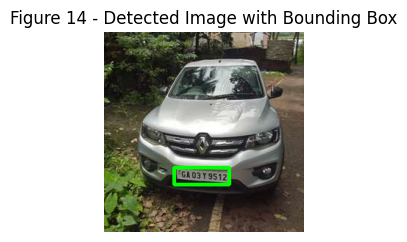

In [81]:
# Create pipeline
path = 'GA12.jpg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h, w, d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

# Display the image with bounding box using Matplotlib
plt.figure(figsize=(7, 5))  # Set the figure size to 700x500 pixels
plt.imshow(image)            # Display the image with bounding box
plt.axis('off')              # Hide axes
plt.title('Figure 14 - Detected Image with Bounding Box')  # Title for the image
plt.tight_layout(pad=10)     # Adjust layout to prevent clipping
plt.show()  

C:\Users\aditi\AppData\Local\Temp\ipykernel_3164\3469473164.py:10: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



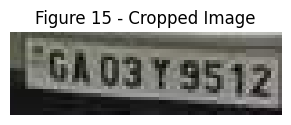

In [82]:
img = np.array(load_img(path))
xmin, xmax, ymin, ymax = cods[0]
roi = img[ymin:ymax, xmin:xmax]

# Display the cropped image using Matplotlib
plt.figure(figsize=(3.5, 2.5))  # Set the figure size to 350x250 pixels
plt.imshow(roi)                  # Display the cropped image
plt.axis('off')                  # Hide axes
plt.title('Figure 15 - Cropped Image')  # Title for the cropped image
plt.tight_layout(pad=10)         # Adjust layout to prevent clipping
plt.show()       

In [85]:
import easyocr

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])  # Specify the languages you want to read

# Extract text from the cropped image
text = reader.readtext(roi)

# Initialize a dictionary for license plate prefixes
states_mapping = {
    "AN": "Andaman and Nicobar Islands",
    "AP": "Andhra Pradesh",
    "AR": "Arunachal Pradesh",
    "AS": "Assam",
    "BR": "Bihar",
    "CG": "Chhattisgarh",
    "CH": "Chandigarh",
    "DD": "Daman and Diu",
    "DL": "Delhi",
    "DN": "Dadra and Nagar Haveli",
    "GA": "Goa",
    "GJ": "Gujarat",
    "HR": "Haryana",
    "HP": "Himachal Pradesh",
    "JH": "Jharkhand",
    "JK": "Jammu and Kashmir",
    "KA": "Karnataka",
    "KL": "Kerala",
    "LD": "Lakshadweep",
    "MH": "Maharashtra",
    "ML": "Meghalaya",
    "MN": "Manipur",
    "MP": "Madhya Pradesh",
    "MZ": "Mizoram",
    "NL": "Nagaland",
    "OD": "Odisha",
    "PB": "Punjab",
    "PY": "Puducherry",
    "RJ": "Rajasthan",
    "SK": "Sikkim",
    "TN": "Tamil Nadu",
    "TR": "Tripura",
    "TS": "Telangana",
    "UK": "Uttarakhand",
    "UP": "Uttar Pradesh",
    "WB": "West Bengal",
    "LA": "Ladakh"
}


# Print the extracted text and determine the state
for detection in text:
    plate_number = detection[1]  # Extract the detected license plate text
    print("Extracted Plate:", plate_number[1:])  # Print the text detected

    # Assuming the license plate number has a specific format,
    # you can extract the prefix (e.g., first 2 letters)
    if len(plate_number) >= 2:
        prefix = plate_number[1:3]  # Get the first two characters
        state = states_mapping.get(prefix)  # Look up the state using the prefix

        if state:
            print(f"The car belongs to: {state}")
        else:
            print("State not found for the extracted plate.")
    else:
        print("Plate number is too short to determine the state.")


Extracted Plate: GA03 y 9512
The car belongs to: Goa
